<a href="https://colab.research.google.com/github/willyptrain/cs4774-mask-detection/blob/main/yolo_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
__author__ = 'wcp7cp'

# General imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import os
import sys
import pandas as pd

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

import scipy.io as sio
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import matplotlib.pyplot as plt
import matplotlib


In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
# !mv 'coco.names' 'drive/My Drive/coco.names'

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #loads the Faster R-CNN model trained on the COCO dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 3
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) #number of classes = 3 : with_mask, without_mask, mask_not_worn_corrected
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.load_state_dict(torch.load('drive/My Drive/final_rcnn.zip',map_location=device))
if torch.cuda.is_available():
    model.cuda()

model.eval()



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

0.9989885687828064 with_mask
0.926945149898529 with_mask
0.6635024547576904 mask_weared_incorrect


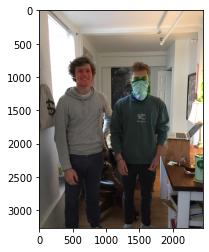

In [16]:

def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1) 
    img = img_tensor.cpu().data

    label_mappings = {"with_mask": 2, "mask_weared_incorrect": 1, "without_mask":0} #0 for background class, not used 
    label_tags = ["without_mask", "mask_weared_incorrect", "with_mask"]
    
    ax.imshow(img.permute(1, 2, 0))
    
    for i, box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        #SHOULD USE OPENCV DNN NMSBOXES => Eliminates problem of overlapping boxes
        if(float(annotation["scores"][i]) > 0.5):   
          print(float(annotation["scores"][i]), label_tags[annotation["labels"][i].item()])       
          color = (0,1,0,0.1) if (annotation["labels"][i] == 2) else (1,0,0,0.1)
          rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
          ax.add_patch(rect)
          # ax.add_patch(rect)

    plt.show()




from torchvision import transforms, datasets, models




tensor_transform = transforms.Compose([
    transforms.ToTensor(),
]) 


test = Image.open('drive/My Drive/one_mask_no_mask.JPG').convert("RGB")#.rotate(270)
test = tensor_transform(test)

# test = test_imgs[0]
test = test.to(device)
preds = model([test])
preds
plot_image(test, preds[0])

In [18]:
yolo_weights = "/content/drive/My Drive/yolov3.weights"
yolo_cfg = "/content/drive/My Drive/yolov3.cfg"
yolo_coco = 'drive/My Drive/coco.names'
net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


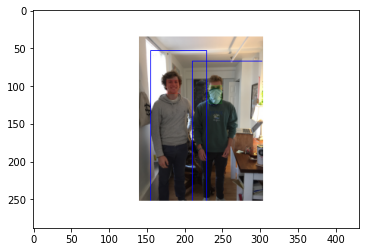

In [104]:

label_tags = ["without_mask", "mask_weared_incorrect", "with_mask"]


def yolo_draw_boxes(img, model):
  blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=True)
  net.setInput(blob)
  feed_forward_output = model.forward(output_layers)
  classes = open(yolo_coco).read().split("\n")
  person_index = classes.index("person")

  boxes = []
  scores = []

  for output in feed_forward_output:
    for detection in output: #shape of detection is (85,1) => index 0-4 for bounding box, index 5 for ____, index 5-85 for scores for each class in coco.names
      
      class_scores = detection[5:]
      person_score = float(class_scores[person_index])
      THRESHOLD = 0.2


      if(person_score > THRESHOLD): #no need for this line, NMSBoxes automatically uses threshold
        b_box = detection[0:4] #center X, center Y, width, height
        b_box = b_box * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]]) #width, height, width, height => scale the image
        b_box = [int(b_box[0] - (b_box[2] / 2)), int(b_box[1] - (b_box[3] / 2)), int(b_box[2]), int(b_box[3])] #xmin, ymin, width, height
          
        boxes.append(b_box)
        scores.append(person_score)


  non_overlap_indeces = cv2.dnn.NMSBoxes(boxes, scores, 0.75, 0.4) #0.5 threshold, 0.4 NMS threshold
  fig,ax = plt.subplots(1) 
  ax.imshow(img)#.permute(1, 2, 0))
  for index in non_overlap_indeces:
    index = int(index)
    xmin = boxes[index][0]
    ymin = boxes[index][1]
    w = boxes[index][2] 
    h = boxes[index][3]
    # xmin = x - (w*0.5)
    # ymin = y - (h*0.5)
    color = (1,0,1,0.99) 
    rect = matplotlib.patches.Rectangle((xmin,ymin),xmin+w,ymin+h,edgecolor=color,facecolor='none')
    ax.add_patch(rect)
  plt.show()





def rcnn_predict(img):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
  img = tensor_transform(img)
  img = img.to(device)
  preds = model([img])
  # for pred in preds:
  # print("Score:", pred["scores"].item(), "\n","Label:", pred["labels"].item())
  # print(preds)
  return preds #will return scores, classes, bounding boxes



def yolo_segment(img, model):
  blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=True)
  net.setInput(blob)
  feed_forward_output = model.forward(output_layers)
  classes = open(yolo_coco).read().split("\n")
  person_index = classes.index("person")

  boxes = []
  scores = []

  for output in feed_forward_output:
    for detection in output: #shape of detection is (85,1) => index 0-4 for bounding box, index 5 for ____, index 5-85 for scores for each class in coco.names
      
      class_scores = detection[5:]
      person_score = float(class_scores[person_index])
      THRESHOLD = 0.2


      
      b_box = detection[0:4] #center X, center Y, width, height
      b_box = b_box * np.array([img.shape[1], img.shape[0], img.shape[1], img.shape[0]]) #width, height, width, height => scale the image
      b_box = [int(b_box[0] - (b_box[2] / 2)), int(b_box[1] - (b_box[3] / 2)), int(b_box[2]), int(b_box[3])] #xmin, ymin, width, height      
      boxes.append(b_box)
      scores.append(person_score)
  
  
  non_overlap_indeces = cv2.dnn.NMSBoxes(boxes, scores, 0.9,0.4)#, 0.8) #0.5 threshold, 0.4 NMS threshold



  fig,ax = plt.subplots(1) 
  ax.imshow(img)#.permute(1, 2, 0))

  for index in non_overlap_indeces: #iterating through person objects
    index = int(index)
    xmin = max(0,boxes[index][0])
    ymin = max(0,boxes[index][1])
    w = boxes[index][2] 
    h = boxes[index][3]

    rect = matplotlib.patches.Rectangle((xmin,ymin),xmin+w,ymin+h,edgecolor=(0,0,1,1),facecolor='none')

    cropped = img[ymin:min(ymin+h,img.shape[1]), xmin:min(xmin+w,img.shape[0])]
    if(cropped.shape[0] > 0 and cropped.shape[1] > 0):
      pillow_img = Image.fromarray(cropped)
      square_w, square_h = pillow_img.size
      size = max(square_h, square_w)
      square_im = Image.new('RGB', (size, size), (0,0,0))
      square_im.paste(pillow_img, (int((size - square_w) / 2), int((size - square_h) / 2)))
      mask_annotations = rcnn_predict(square_im)
      if(len(mask_annotations[0]["labels"]) == 0):
        rect = matplotlib.patches.Rectangle((xmin,ymin),xmin+w,ymin+h,edgecolor=(1,0,0,1),facecolor=(1,0,0,0.1))
      for i,box in enumerate(mask_annotations[0]["boxes"]):
        mask_xmin, mask_ymin, mask_xmax, mask_ymax = box
        if(float(mask_annotations[0]["scores"][i]) > 0.5):   
          color = (0,1,0,0.1) if (mask_annotations[0]["labels"][i] == 2) else (1,0,0,0.1)
          mask_rect = matplotlib.patches.Rectangle((xmin+mask_xmin-(0.5*(size-square_w)),ymin+mask_ymin-(0.5*(size-square_h))),mask_xmax-mask_xmin,mask_ymax-mask_ymin,edgecolor=color,facecolor=color)
          ax.add_patch(mask_rect)

    ax.axis("off")
    ax.add_patch(rect)


  fig.canvas.draw()
  img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,sep='')
  
  fig_dim = fig.canvas.get_width_height()[::-1]
  img  = img.reshape(fig_dim + (3,))#((min(img.shape[0],fig_dim[0]),min(img.shape[1],fig_dim[1]))+(3,))#fig.canvas.get_width_height()[::-1] + (3,))
  
  plt.clf()
  return img


img = cv2.cvtColor(cv2.imread('drive/My Drive/one_mask_no_mask.JPG'), cv2.COLOR_BGR2RGB) #cv2.COLOR_BGR2RGB MUST BE SPECIFIED, reversing channels will hurt model performance

# rcnn_predict(img)
segment = yolo_segment(img, net)
plt.imshow(segment)
plt.show()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


<Figure size 432x288 with 0 Axes>

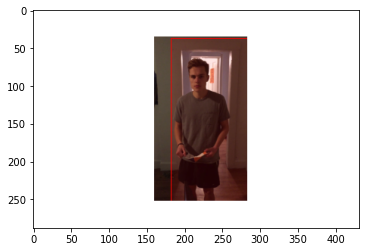

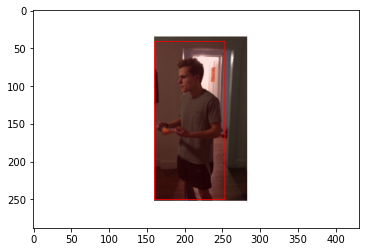

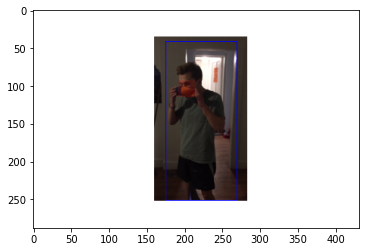

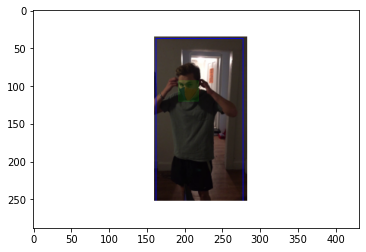

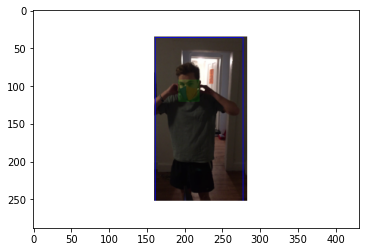

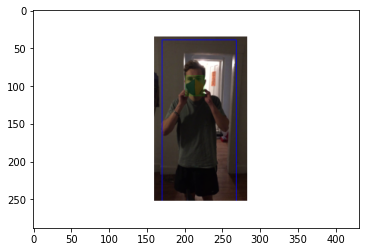

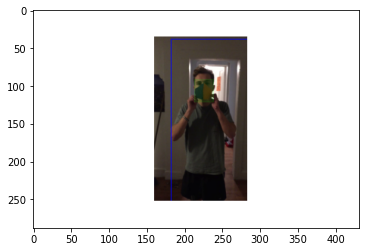

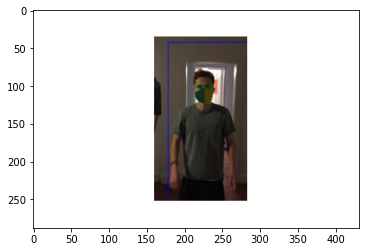

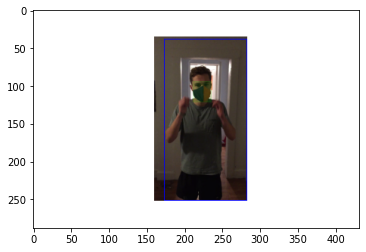

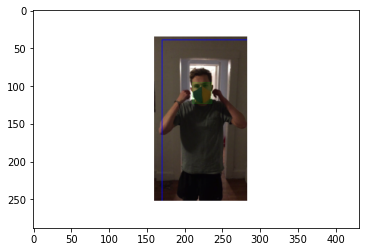

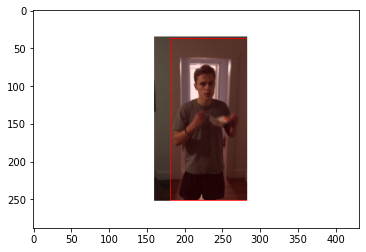

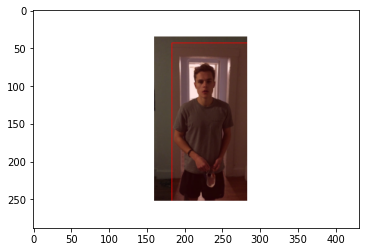

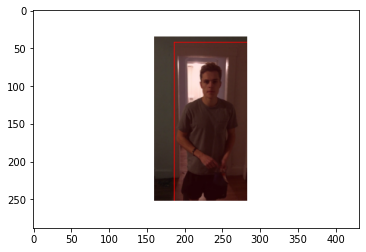

In [107]:
# model.eval()
frame_count = 0
frames = []
capture = cv2.VideoCapture('IMG_0157.mp4')  
step = 20  
while True:
    ret, frame = capture.read()
    
    if not ret:
        break        
    


    frame_count += 1
    # print(frame_count)
    # print(frame.shape)
    if(frame_count % step == 0):
      frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



# # w,h,d = frame_w_boxes.shape
test = yolo_segment(frames[0], net)
# video = cv2.VideoWriter('content/test.avi',0,1,)

# fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

video = cv2.VideoWriter('video.mp4', fourcc, 20.0, (test.shape[0],test.shape[1]))

for frame in frames:
  frame_w_boxes = yolo_segment(frame, net)
  plt.imshow(frame_w_boxes)
  plt.show()
  # print(type(frame_w_boxes))
  # video.write(frame_w_boxes)  


cv2.destroyAllWindows()
video.release()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


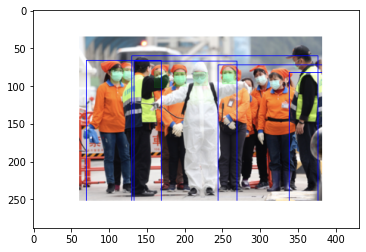

In [108]:
# !unzip -q 'drive/My Drive/face_mask_detection.zip' 

img = cv2.cvtColor(cv2.imread('/content/images/maksssksksss3.png'), cv2.COLOR_BGR2RGB) #cv2.COLOR_BGR2RGB MUST BE SPECIFIED, reversing channels will hurt model performance

# rcnn_predict(img)
crop = yolo_segment(img, net)
plt.imshow(crop)
plt.show()